# Bank Teller Queue Simulation & Wait Time Prediction

**Objective:**
This notebook simulates a bank queueing system using `simpy`. By generating randomized parameters for arrival rates, service rates, and the number of tellers, we can simulate how long customers wait in line. Once the data is generated, we will use various Machine Learning regression models to predict the `mean_wait` time based on those parameters.

In [12]:
!pip install simpy -q

import simpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# no warning 
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
#model
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor


[notice] A new release of pip is available: 26.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
#lower and upper bound for simul
sim_limits = {
    'arr_rate': (0.5, 5.0),   
    'srv_rate': (0.5, 5.0),   
    'tellers': (1, 5),       
    'duration': (60, 300)    
}

print('Using the following bounds:')
for k, (b_low, b_high) in sim_limits.items():
    print(f'  {k} -> [{b_low}, {b_high}]')

Using the following bounds:
  arr_rate -> [0.5, 5.0]
  srv_rate -> [0.5, 5.0]
  tellers -> [1, 5]
  duration -> [60, 300]


In [14]:
def run_queue_sim(arr_rate, srv_rate, tellers, duration, random_seed=None):
    gen = np.random.default_rng(random_seed)
    w_times = []
    
    sim_env = simpy.Environment()
    staff = simpy.Resource(sim_env, capacity=int(tellers))
    
    def client(sim_env, name, staff):
        time_in = sim_env.now
        with staff.request() as r:
            yield r
            w_times.append(sim_env.now - time_in)
            t_service = gen.exponential(1.0 / srv_rate)
            yield sim_env.timeout(t_service)
    
    def spawn_clients(sim_env):
        idx = 0
        while True:
            t_inter = gen.exponential(1.0 / arr_rate)
            yield sim_env.timeout(t_inter)
            sim_env.process(client(sim_env, f'c_{idx}', staff))
            idx += 1
            
    sim_env.process(spawn_clients(sim_env))
    sim_env.run(until=duration)
    
    if len(w_times) > 0:
        mean_w = np.mean(w_times)
        max_w = np.max(w_times)
    else:
        mean_w, max_w = 0.0, 0.0
        
    n_cust = len(w_times)
    return mean_w, n_cust, max_w

#1000 simultaions
np.random.seed(123) 
NUM_RUNS = 1000
sim_data = []

print(f'Starting {NUM_RUNS} runs...')

for step in range(NUM_RUNS):
    a_rate = np.random.uniform(*sim_limits['arr_rate'])
    s_rate = np.random.uniform(*sim_limits['srv_rate'])
    n_tellers = np.random.randint(sim_limits['tellers'][0], sim_limits['tellers'][1] + 1)
    t_total = np.random.uniform(*sim_limits['duration'])
    
    m_wait, total_c, mx_wait = run_queue_sim(a_rate, s_rate, n_tellers, t_total, random_seed=step)
    
    sim_data.append({
        'arr_rate': round(a_rate, 4),
        'srv_rate': round(s_rate, 4),
        'tellers': n_tellers,
        'duration': round(t_total, 2),
        'mean_wait': round(m_wait, 4),
        'total_cust': total_c,
        'max_wait': round(mx_wait, 4)
    })
    
    # print after 250
    if (step + 1) % 250 == 0:
        print(f'  progress: {step+1}/{NUM_RUNS}')

df = pd.DataFrame(sim_data)
print(f'\ndone. dataframe size: {df.shape[0]} rows x {df.shape[1]} cols')
df.head()

Starting 1000 runs...
  progress: 250/1000
  progress: 500/1000
  progress: 750/1000
  progress: 1000/1000

done. dataframe size: 1000 rows x 7 cols


,arr_rate,srv_rate,tellers,duration,mean_wait,total_cust,max_wait
0,3.6341,1.7876,5,225.81,0.0427,823,1.3192
1,3.7362,2.7100,2,295.38,0.2986,1113,2.5859
2,3.5817,2.6642,2,156.24,0.2287,593,1.9275
3,3.3229,1.9587,5,155.53,0.0141,507,0.9860
4,3.8210,1.3212,3,80.09,1.8828,296,4.9271


## Exploratory Data Analysis (EDA)

       arr_rate  srv_rate   tellers  duration  mean_wait  total_cust  max_wait
count  1000.000  1000.000  1000.000  1000.000   1000.000    1000.000  1000.000
mean      2.738     2.777     2.980   183.757      6.441     450.740    13.657
std       1.304     1.315     1.399    67.593     17.060     281.159    33.804
min       0.502     0.503     1.000    60.650      0.000      33.000     0.000
25%       1.589     1.645     2.000   127.958      0.001     229.750     0.151
50%       2.820     2.755     3.000   181.700      0.028     404.000     0.752
75%       3.852     3.935     4.000   243.612      0.709     618.000     4.225
max       4.991     4.996     5.000   299.780    117.909    1452.000   230.263


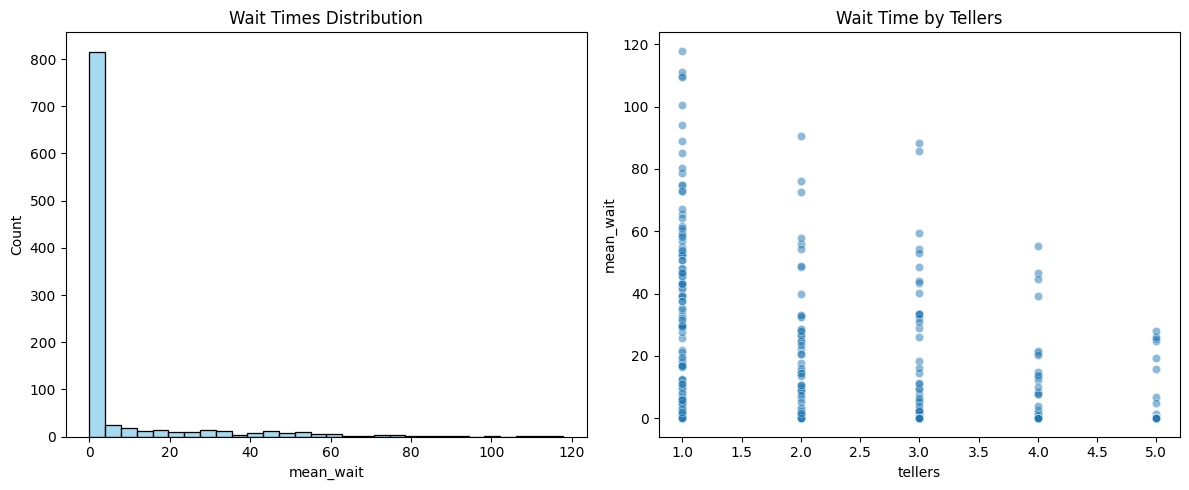

In [19]:
print(df.describe().round(3))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df['mean_wait'], bins=30, ax=axes[0], color='skyblue')
axes[0].set_title('Wait Times Distribution')

sns.scatterplot(x='tellers', y='mean_wait', data=df, ax=axes[1], alpha=0.5)
axes[1].set_title('Wait Time by Tellers')

plt.tight_layout()
plt.savefig('eda_plots.png')
plt.show()

## Machine Learning Evaluation
We will treat predicting the `mean_wait` as a regression problem and atest several algorithms to see which maps the relationships between arrival rate, service rate, and teller count most accurately.

In [20]:
# sep features and target
X = df[['arr_rate', 'srv_rate', 'tellers', 'duration']]
y = df['mean_wait']

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=99)

# scale the feature
scl = StandardScaler()
X_tr_s = scl.fit_transform(X_tr)
X_te_s = scl.transform(X_te)
#evaluations models
models_to_test = {
    'LinearReg': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'DT': DecisionTreeRegressor(),
    'RF': RandomForestRegressor(n_estimators=100, random_state=45),
    'GBM': GradientBoostingRegressor(random_state=45),
    'ExtraTrees': ExtraTreesRegressor(random_state=45),
    'SVM': SVR(),
    'KNN': KNeighborsRegressor(),
    'MLP': MLPRegressor(max_iter=500, random_state=45)
}

In [21]:
res = []
best_r2 = -999
best_mdl_name = ""
best_preds = None

for name, m in models_to_test.items():
    m.fit(X_tr_s, y_tr)
    preds = m.predict(X_te_s)
    
    rmse_val = np.sqrt(mean_squared_error(y_te, preds))
    mae_val = mean_absolute_error(y_te, preds)
    r2_val = r2_score(y_te, preds)
    
    res.append({'Model': name, 'RMSE': rmse_val, 'MAE': mae_val, 'R2': r2_val})
    
    # keep track of the top performing model fro r2 score
    if r2_val > best_r2:
        best_r2 = r2_val
        best_mdl_name = name
        best_preds = preds

# sort by R2 descending
res_df = pd.DataFrame(res).set_index('Model').sort_values(by='R2', ascending=False)
res_df.head(10)

,RMSE,MAE,R2
Model,,,
ExtraTrees,3.883985,1.393025,0.955758
RF,5.010692,1.824177,0.926367
GBM,5.820943,2.757594,0.900628
MLP,6.044710,2.841200,0.892841
KNN,6.059365,2.205419,0.892321
DT,8.486573,2.820642,0.788777
LinearReg,14.146011,8.835467,0.413126
Ridge,14.147644,8.831511,0.412991
Lasso,14.493694,8.251116,0.383923


Files successfully saved:
   - simul_data.csv
   - model_comparison_results.csv
   - eda_plots.png
   - model_comparison.png
   - actual_vs_predicted.png

Best Model: ExtraTrees


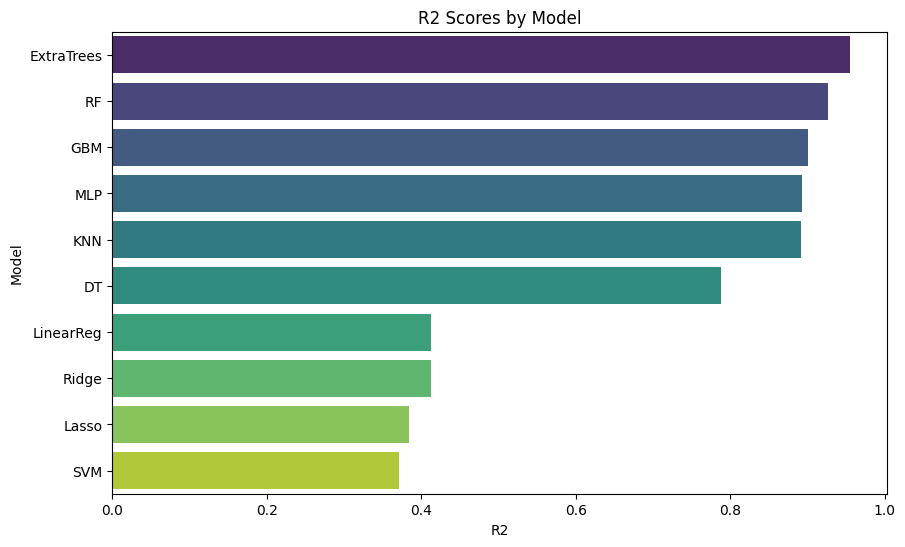

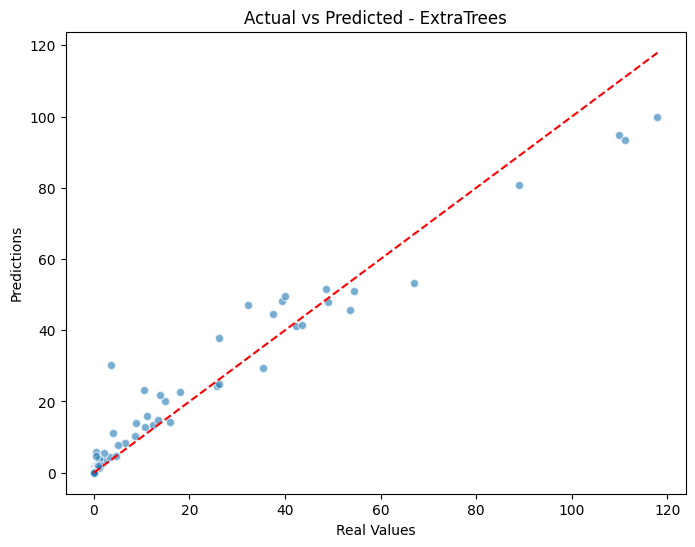

In [22]:
# model compy
plt.figure(figsize=(10, 6))
sns.barplot(x=res_df['R2'], y=res_df.index, hue=res_df.index, palette='viridis', legend=False)
plt.title('R2 Scores by Model')
plt.savefig('model_comparison.png')

# actual vs opred
plt.figure(figsize=(8, 6))
plt.scatter(y_te, best_preds, alpha=0.6, edgecolors='w')
plt.plot([y_te.min(), y_te.max()], [y_te.min(), y_te.max()], 'r--') # ideal fit line
plt.xlabel('Real Values')
plt.ylabel('Predictions')
plt.title(f'Actual vs Predicted - {best_mdl_name}')
plt.savefig('actual_vs_predicted.png')

# export 
df.to_csv('simul_data.csv', index=False)
res_df.to_csv('model_comparison_results.csv', index=True)

print('Files successfully saved:')
print('   - simul_data.csv')
print('   - model_comparison_results.csv')
print('   - eda_plots.png')
print('   - model_comparison.png')
print('   - actual_vs_predicted.png')
print(f'\nBest Model: {best_mdl_name}')